# Take Home Test : Sameer Darekar

### Goal: Get Insights into the travel behaviour of the user.

Questions to answer:
1. How many unique “locations” does the user visit? <strong>(TL;DR 6)</strong>
2. What are the top 3 locations visited by this user? <strong>(TL;DR Atherton, San Jose, Menlo Park)</strong>
3. Bonus: what other insights can you obtain about the travel behavior of this user? <strong>(answer in last cell)</strong>


I will try 2 approaches 1st will be a Naive approach where I will do analysis by time spent at each data point by considering the difference between previous data point and speed between two data points. As per general knowledge we can say that whenever a person is visiting any particular location he is walking or taking a hault at that point hence the speed will be less and time spend at that point will be more, I will use this fact in this case.

Secondly I will try clustering using the latitudes, longitude and add a third dimentsion of time known as datum difference(time difference from first point) once the clusters are defined I can do further analysis on inter cluster data by considering speeds and time spent.

Assuming Date time are in PST.

## 1. Naive Approach

In [301]:
import pandas as pd
df = pd.read_csv("ds_challenge_latlongtimestamp_data.csv")
df.head()

,timestamp,latitude,longitude
0,2018-03-22 09:20:04.360,37.466694,-122.196464
1,2018-03-22 09:20:18.072,37.465406,-122.197837
2,2018-03-22 09:21:02.410,37.462142,-122.200287
3,2018-03-22 09:21:49.000,37.462164,-122.199864
4,2018-03-22 09:22:28.000,37.461404,-122.198902


In [298]:
df.tail()

,timestamp,latitude,longitude
836,2018-03-24 22:48:31.616,37.872299,-122.274427
837,2018-03-24 22:52:25.916,37.872341,-122.274387
838,2018-03-24 23:32:54.991,37.872376,-122.274322
839,2018-03-24 23:56:31.033,37.872376,-122.274322
840,2018-03-24 23:57:00.033,37.872512,-122.274251


### First Look at the data:

The Following is the image of all the points on the map plotted using http://www.copypastemap.com/.        
By looking at the following data I assume that the user has stoped at 6 unique locations viz: Berkeley, San Francisco, San Carlos, Atherton, Menlo Park and San Jose.    
In these 6 locations he might have visited multiple places which further needs to be analysed

![Plot](plots.jpg "Plot of all points on map")

In [299]:
import numpy as np
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the Haversine distance between two points
    on the earth (specified in decimal degrees)
    
    Returns: distance in miles

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    mi = 3958.8 * c # earth's radius in miles = 3958.8
    return mi

In [300]:
df.timestamp = pd.to_datetime(df['timestamp'])
# Calculate distance between 2 consecutive data points
df['dist'] = haversine_np(df.longitude.shift(), df.latitude.shift(), df.longitude, df.latitude)

# Calculate time difference between 2 consecutive data points
df['timedelta'] = df.timestamp.diff()
df = df.fillna(0)

df.head()

,timestamp,latitude,longitude,dist,timedelta
0,2018-03-22 09:20:04.360,37.466694,-122.196464,0.000000,00:00:00
1,2018-03-22 09:20:18.072,37.465406,-122.197837,0.116612,00:00:13.712000
2,2018-03-22 09:21:02.410,37.462142,-122.200287,0.262487,00:00:44.338000
3,2018-03-22 09:21:49.000,37.462164,-122.199864,0.023235,00:00:46.590000
4,2018-03-22 09:22:28.000,37.461404,-122.198902,0.074445,00:00:39


In [113]:
import json 
import requests

def getAddress(lat, long):
    """
    Get the address by using reverse geocoding
    
    Returns: geo details

    """
    appId = 'P0cwhaZuxEA98DfTtJT8'
    appCode = 'Dwnc-gRjX_ruuAaq_y_zQg'
    url = "https://reverse.geocoder.api.here.com/6.2/reversegeocode.json?prox={}%2C{}%2C100&mode=retrieveAddresses&maxresults=1&gen=9&app_id={}&app_code={}".format(lat, long, appId, appCode)
    
    r = requests.get(url).json()
    
    locationData = r['Response']['View'][0]['Result'][0]['Location']['Address']

    return locationData


In [116]:
df['geo'] = df.apply(lambda x: getAddress(x.latitude, x.longitude))
df.head()

,timestamp,latitude,longitude,dist,timedelta,geo
0,2018-03-22 09:20:04.360,37.466694,-122.196464,0.000000,00:00:00,"{'Label': '145 Fair Oaks Ln, Atherton, CA 9402..."
1,2018-03-22 09:20:18.072,37.465406,-122.197837,0.116612,00:00:13.712000,"{'Label': '107 Fair Oaks Ln, Atherton, CA 9402..."
2,2018-03-22 09:21:02.410,37.462142,-122.200287,0.262487,00:00:44.338000,"{'Label': 'El Camino Real, Atherton, CA 94027,..."
3,2018-03-22 09:21:49.000,37.462164,-122.199864,0.023235,00:00:46.590000,"{'Label': '501 El Camino Real, Atherton, CA 94..."
4,2018-03-22 09:22:28.000,37.461404,-122.198902,0.074445,00:00:39,"{'Label': '574 El Camino Real, Atherton, CA 94..."


In [150]:
geoDF = pd.io.json.json_normalize(df.geo)[['City', 'County', 'Label', 'PostalCode']]

# enrich the data using the geo data
enrichedDF = pd.concat([df,geoDF], axis=1)

enrichedDF.drop(['geo'], axis=1, inplace=True)

# convert time delta to seconds
enrichedDF.timedelta = enrichedDF.timedelta.dt.total_seconds()
enrichedDF.head()

,timestamp,latitude,longitude,dist,timedelta,City,County,Label,PostalCode
0,2018-03-22 09:20:04.360,37.466694,-122.196464,0.000000,0.000,Atherton,San Mateo,"145 Fair Oaks Ln, Atherton, CA 94027, United S...",94027
1,2018-03-22 09:20:18.072,37.465406,-122.197837,0.116612,13.712,Atherton,San Mateo,"107 Fair Oaks Ln, Atherton, CA 94027, United S...",94027
2,2018-03-22 09:21:02.410,37.462142,-122.200287,0.262487,44.338,Atherton,San Mateo,"El Camino Real, Atherton, CA 94027, United States",94027
3,2018-03-22 09:21:49.000,37.462164,-122.199864,0.023235,46.590,Atherton,San Mateo,"501 El Camino Real, Atherton, CA 94027, United...",94027
4,2018-03-22 09:22:28.000,37.461404,-122.198902,0.074445,39.000,Atherton,San Mateo,"574 El Camino Real, Atherton, CA 94027, United...",94027


In [186]:
# Calculate speed in miles per second
enrichedDF['speed'] = enrichedDF.dist / enrichedDF.timedelta
enrichedDF['index'] = enrichedDF.index
enrichedDF.head()

,timestamp,latitude,longitude,dist,timedelta,City,County,Label,PostalCode,speed,index
0,2018-03-22 09:20:04.360,37.466694,-122.196464,0.000000,0.000,Atherton,San Mateo,"145 Fair Oaks Ln, Atherton, CA 94027, United S...",94027,NaN,0
1,2018-03-22 09:20:18.072,37.465406,-122.197837,0.116612,13.712,Atherton,San Mateo,"107 Fair Oaks Ln, Atherton, CA 94027, United S...",94027,0.008504,1
2,2018-03-22 09:21:02.410,37.462142,-122.200287,0.262487,44.338,Atherton,San Mateo,"El Camino Real, Atherton, CA 94027, United States",94027,0.005920,2
3,2018-03-22 09:21:49.000,37.462164,-122.199864,0.023235,46.590,Atherton,San Mateo,"501 El Camino Real, Atherton, CA 94027, United...",94027,0.000499,3
4,2018-03-22 09:22:28.000,37.461404,-122.198902,0.074445,39.000,Atherton,San Mateo,"574 El Camino Real, Atherton, CA 94027, United...",94027,0.001909,4


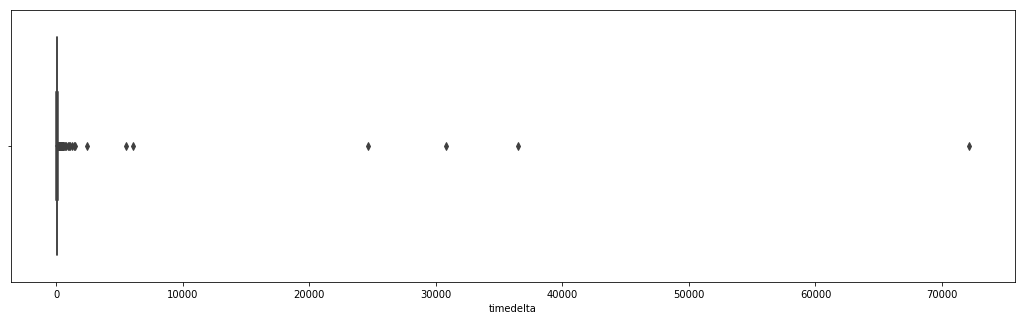

In [462]:
fig = plt.figure(figsize=(18,5))
sns.boxplot(x=enrichedDF["timedelta"])

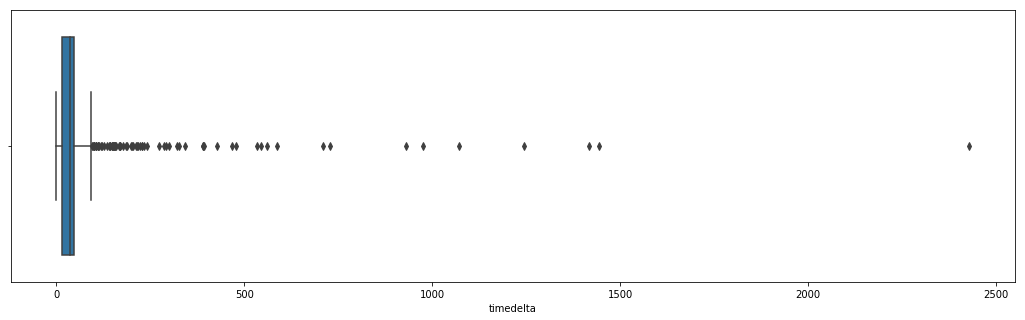

In [465]:
# remove oputliers and try to gain details
fig = plt.figure(figsize=(18,5))
sns.boxplot(x=enrichedDF[enrichedDF.timedelta<2500]["timedelta"])

Observations: most of the timedelta values i.e difference between timestamp of 2 successive data points are closer to 0

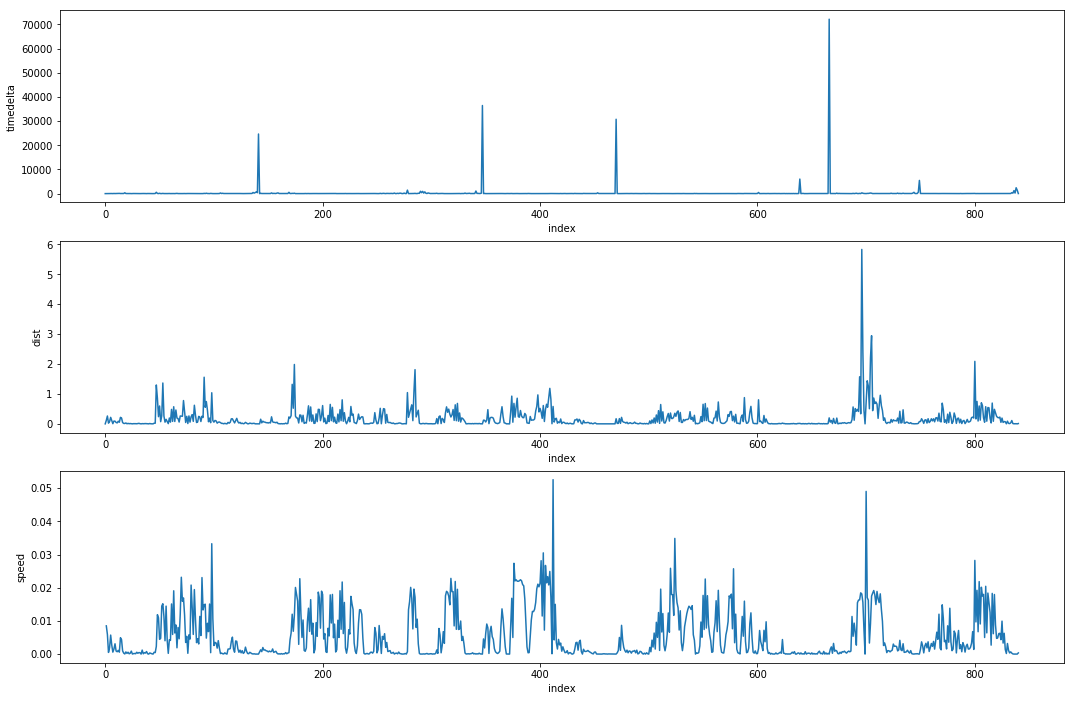

In [211]:
fig = plt.figure(figsize=(18,12))

ax1 = plt.subplot(3, 1, 1)
ax1 = sns.lineplot(x="index", y="timedelta", data=enrichedDF)

ax2 = plt.subplot(3, 1, 2, sharex=ax1)
ax2 = sns.lineplot(x="index", y="dist", data=enrichedDF)

ax3 = plt.subplot(3, 1, 3, sharex=ax1)
ax3 = sns.lineplot(x="index", y="speed", data=enrichedDF)

plt.show()

Analysis of Speed, distance traveled and timedelta between 2 successive data points on a common x axis indicates corresponding time delta values for which the the value is high have almost zero speed and distance travelled.

In [239]:
enrichedDF[enrichedDF.timedelta>=enrichedDF.timedelta.quantile(q=0.99)].head(20)
#list of possibly visited places

,timestamp,latitude,longitude,dist,timedelta,City,County,Label,PostalCode,speed,index
141,2018-03-22 18:26:40.001,37.336975,-121.889387,0.000000,24665.806,San Jose,Santa Clara,"75 E Santa Clara St, San Jose, CA 95113, Unite...",95113,0.000000,141
278,2018-03-22 20:47:04.599,37.483396,-122.180382,1.045580,1444.440,Menlo Park,San Mateo,"US-101, Menlo Park, CA 94025, United States",94025,0.000724,278
347,2018-03-23 09:06:31.000,37.473368,-122.194624,0.000000,36458.775,Menlo Park,San Mateo,"550 San Benito Ave, Menlo Park, CA 94025, Unit...",94025,0.000000,347
470,2018-03-23 18:52:03.586,37.335509,-121.891904,0.171021,30771.229,San Jose,Santa Clara,"2 S Market St, San Jose, CA 95113, United States",95113,0.000006,470
639,2018-03-23 21:57:02.309,37.473338,-122.194728,0.014817,6021.310,Menlo Park,San Mateo,"544 San Benito Ave, Menlo Park, CA 94025, Unit...",94025,0.000002,639
666,2018-03-24 18:11:07.956,37.470716,-122.195691,0.199568,72169.682,Atherton,San Mateo,"57 San Benito Ave, Atherton, CA 94027, United ...",94027,0.000003,666
749,2018-03-24 21:28:46.011,37.786446,-122.431474,0.078692,5469.155,San Francisco,San Francisco,"1700 Webster St, San Francisco, CA 94115, Unit...",94115,0.000014,749
838,2018-03-24 23:32:54.991,37.872376,-122.274322,0.004300,2429.075,Berkeley,Alameda,"1821 Berkeley Way, Berkeley, CA 94703, United ...",94703,0.000002,838
839,2018-03-24 23:56:31.033,37.872376,-122.274322,0.000000,1416.042,Berkeley,Alameda,"1821 Berkeley Way, Berkeley, CA 94703, United ...",94703,0.000000,839


Text(0.5,1,'TimeDelta spikes corresponding to data mentioned above(indicated in red line)')

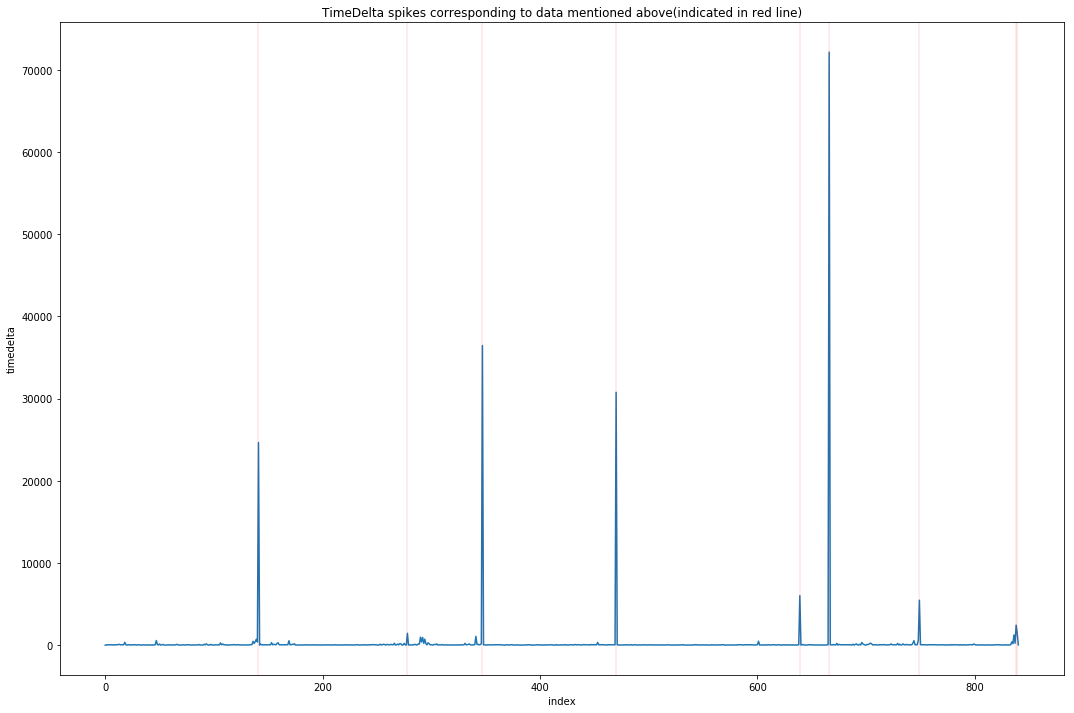

In [295]:
fig = plt.figure(figsize=(18,12))
ax1 = sns.lineplot(x="index", y="timedelta", data=enrichedDF)
xcoords = enrichedDF[enrichedDF.timedelta>=enrichedDF.timedelta.quantile(q=0.99)].head(20).index
for xc in xcoords:
    plt.axvline(x=xc, c='r', alpha=0.1)
plt.title('TimeDelta spikes corresponding to data mentioned above(indicated in red line)')

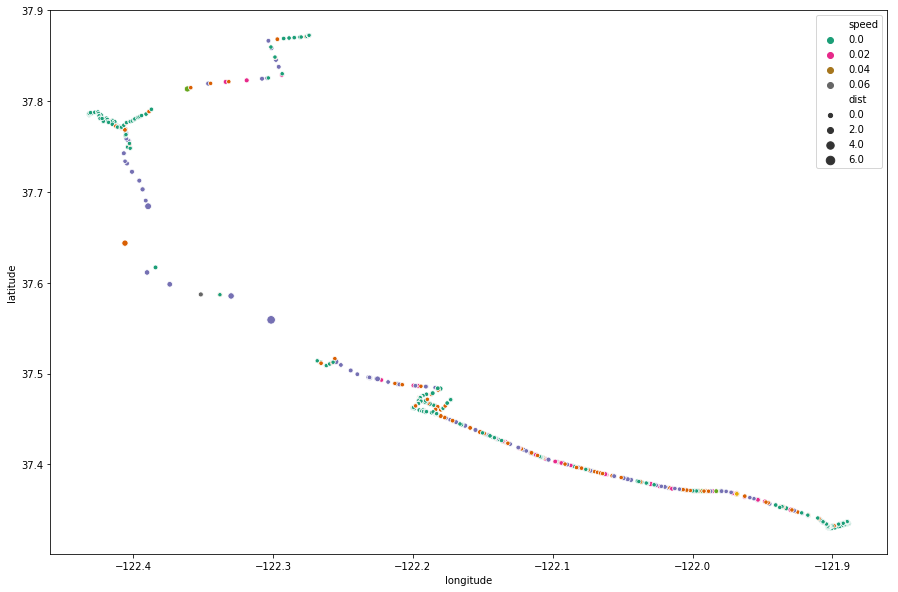

In [286]:
fig, ax = plt.subplots(figsize=[15, 10])
ax = sns.scatterplot(x="longitude", y="latitude", 
                     hue='speed', size="dist",
                     palette='Dark2', data=enrichedDF)

In the above plot all the points marked in green seem to be stationary points or the ones with very less speed.
We can say that the user is either walking or stationary hence the low speeds. The size of the dots vary as per speed.

These points are primarily in the region of San Jose, Atherton, Menlo Park, San Francisco and Berkeley which can be confirmed with the data frame above the plot which gives places where the time delta was greater than 99 percentile also the plot indicating the spikes in timedelata. Hence we can say with some certainty that the user has visited these places.

The addresses are as follows(Note that the addresses have a proximity of 100 meters):
1. 75 E Santa Clara St, San Jose on 22 at 18:26
2. US-101, Menlo Park, CA 94025 on 22 at 22:47
3. 550 San Benito Ave, Menlo Park on 23 at 09:06
4. 2 S Market St, San Jose on 23 at 18:52
5. 544 San Benito Ave, Menlo Park on 23 at 21:57
6. 57 San Benito Ave, Atherton on 24 at 18:11
7. 1700 Webster St, San Francisco on 24 at 21:28
8. 1821 Berkeley Way, Berkeley on 24 at 23:32 and 23:56

the addresses 2 and 3 are close by hence we can ignore and say that the user slept on 22 at address 3.   
the addresses 5 and 6 are close as well, we dont have data for 24 before 6 pm, hence assuming that the user slept on address 5 or 6 for the night on 23.

So the <strong> user visited 5 unique locations</strong> 
and <strong> Among the top 3 visited locations Menlo Park and San Jose are for sure but with little skepticism I can say Atherton as it was the place where the user started </strong>

## 2. Clustering Approach 

In [305]:
# Add extra dimentsion in spatial data lets call that as Datum difference 
# where datum or reference point is the first value of the data set
# the reason for doing this is we want continous clusters in space and time
enrichedDF['datumDifference'] = (enrichedDF.timestamp - enrichedDF.timestamp[0]).dt.total_seconds()/60
enrichedDF.head()

,timestamp,latitude,longitude,dist,timedelta,City,County,Label,PostalCode,speed,index,datumDifference
0,2018-03-22 09:20:04.360,37.466694,-122.196464,0.000000,0.000,Atherton,San Mateo,"145 Fair Oaks Ln, Atherton, CA 94027, United S...",94027,NaN,0,0.000000
1,2018-03-22 09:20:18.072,37.465406,-122.197837,0.116612,13.712,Atherton,San Mateo,"107 Fair Oaks Ln, Atherton, CA 94027, United S...",94027,0.008504,1,0.228533
2,2018-03-22 09:21:02.410,37.462142,-122.200287,0.262487,44.338,Atherton,San Mateo,"El Camino Real, Atherton, CA 94027, United States",94027,0.005920,2,0.967500
3,2018-03-22 09:21:49.000,37.462164,-122.199864,0.023235,46.590,Atherton,San Mateo,"501 El Camino Real, Atherton, CA 94027, United...",94027,0.000499,3,1.744000
4,2018-03-22 09:22:28.000,37.461404,-122.198902,0.074445,39.000,Atherton,San Mateo,"574 El Camino Real, Atherton, CA 94027, United...",94027,0.001909,4,2.394000


In [306]:
enrichedDF.tail()

,timestamp,latitude,longitude,dist,timedelta,City,County,Label,PostalCode,speed,index,datumDifference
836,2018-03-24 22:48:31.616,37.872299,-122.274427,0.002896,1243.741,Berkeley,Alameda,"1818 Berkeley Way, Berkeley, CA 94703, United ...",94703,0.000002,836,3688.454267
837,2018-03-24 22:52:25.916,37.872341,-122.274387,0.003608,234.300,Berkeley,Alameda,"1819 Berkeley Way, Berkeley, CA 94703, United ...",94703,0.000015,837,3692.359267
838,2018-03-24 23:32:54.991,37.872376,-122.274322,0.004300,2429.075,Berkeley,Alameda,"1821 Berkeley Way, Berkeley, CA 94703, United ...",94703,0.000002,838,3732.843850
839,2018-03-24 23:56:31.033,37.872376,-122.274322,0.000000,1416.042,Berkeley,Alameda,"1821 Berkeley Way, Berkeley, CA 94703, United ...",94703,0.000000,839,3756.444550
840,2018-03-24 23:57:00.033,37.872512,-122.274251,0.010217,29.000,Berkeley,Alameda,"1825 Berkeley Way, Berkeley, CA 94703, United ...",94703,0.000352,840,3756.927883


In [424]:
from sklearn.cluster import KMeans

X = enrichedDF[['latitude', 'longitude', 'datumDifference']]
kmeans = KMeans(n_clusters=20, random_state=0).fit(X)
enrichedDF['kmeansLabel'] = kmeans.labels_

Text(0.5,1,'Visualization of K-means clusters')

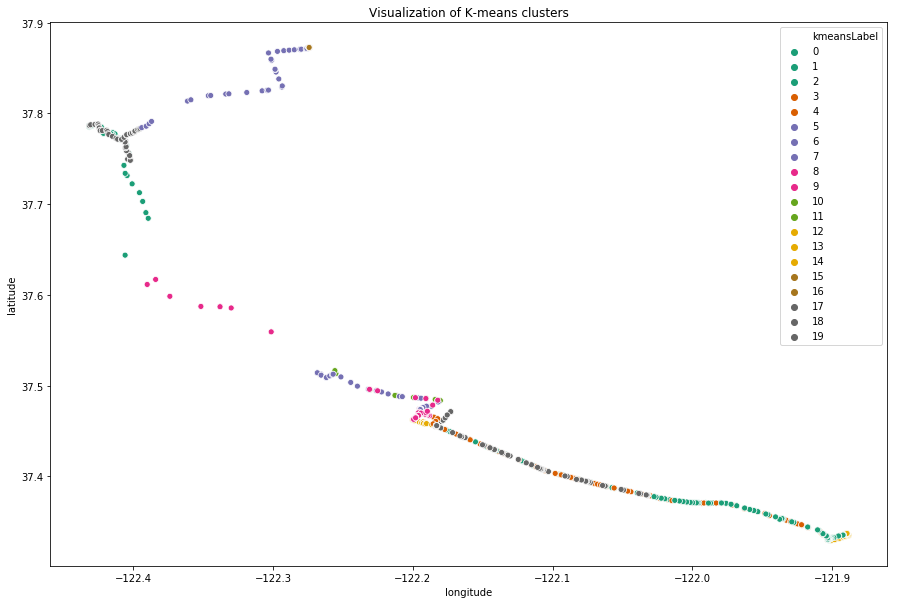

In [425]:
fig, ax = plt.subplots(figsize=[15, 10])
ax = sns.scatterplot(x="longitude", y="latitude", 
                     hue='kmeansLabel', legend='full',
                     palette='Dark2', data=enrichedDF)
plt.title('Visualization of K-means clusters')

In [426]:
kmeansGrouped = enrichedDF.groupby('kmeansLabel').sum()[['dist','timedelta']].reset_index()
# avg speed = total distance travelled / total time taken
kmeansGrouped['avgSpeed'] = (kmeansGrouped.dist * 3600 / kmeansGrouped.timedelta) #in mph
kmeansGrouped.head(20)

,kmeansLabel,dist,timedelta,avgSpeed
0,0,18.113390,2662.000,24.495944
1,1,9.117243,32554.643,1.008215
2,2,13.942826,3892.902,12.893767
3,3,20.126353,38709.775,1.871746
4,4,17.999922,2531.000,25.602418
5,5,6.969969,4400.731,5.701755
6,6,11.320209,3276.740,12.436981
7,7,0.149237,6697.275,0.080220
8,8,1.765068,1525.999,4.163991
9,9,18.340529,74665.680,0.884287


In [427]:
# The labels are continous 
kmeans.labels_

array([13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [444]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=3, min_samples=2).fit(X)
enrichedDF['dbscanLabel'] = dbscan.labels_

Text(0.5,1,'Visualization of DBSCAN clusters')

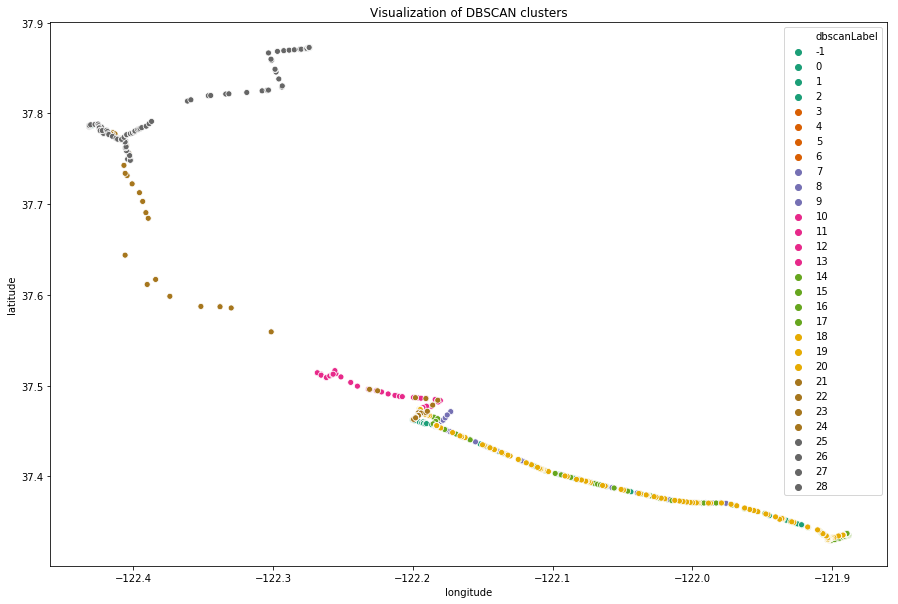

In [445]:
fig, ax = plt.subplots(figsize=[15, 10])
ax = sns.scatterplot(x="longitude", y="latitude", 
                     hue='dbscanLabel', legend='full',
                     palette='Dark2', data=enrichedDF)
plt.title('Visualization of DBSCAN clusters')

In [446]:
dbscanGrouped = enrichedDF.groupby('dbscanLabel').sum()[['dist','timedelta']].reset_index()
# speed in mph
dbscanGrouped['avgSpeed'] = (dbscanGrouped.dist * 3600 / dbscanGrouped.timedelta)
dbscanGrouped.head(40)

,dbscanLabel,dist,timedelta,avgSpeed
0,-1,0.272821,10212.812,0.096169
1,0,1.684013,771.640,7.856574
2,1,0.229464,1158.000,0.713359
3,2,18.062013,2564.045,25.359635
4,3,1.294863,1436.647,3.244713
5,4,0.576649,25186.805,0.082422
6,5,0.440060,563.000,2.813880
7,6,0.071277,701.997,0.365527
8,7,21.322447,3896.068,19.702122
9,8,0.053281,445.858,0.430209


In [447]:
# The labels are continous except for some labels with -1, they are the data points not in any cluster
dbscan.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
       -1, -1, -1, -1, -1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        5,  5,  5,  5,  5, -1,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7

All these points in the clusters seem to be continous in space and time hence lets focus on the points where the average speed was less than 3 mph(walking speed) and get two sample from each cluster and plot them on the graph

In [472]:
hypothesizedStationary = dbscanGrouped[dbscanGrouped.avgSpeed<3]
# Remove noisy points
hypothesizedStationary = hypothesizedStationary[hypothesizedStationary.dbscanLabel != -1]

hypothesizedStationary.head()

,dbscanLabel,dist,timedelta,avgSpeed
2,1,0.229464,1158.000,0.713359
5,4,0.576649,25186.805,0.082422
6,5,0.440060,563.000,2.813880
7,6,0.071277,701.997,0.365527
9,8,0.053281,445.858,0.430209
10,9,0.046207,386.197,0.430723
11,10,0.011525,267.036,0.155374
13,12,0.023926,936.354,0.091986
15,14,0.119927,734.285,0.587969
16,15,0.038257,1536.187,0.089653


In [493]:
# Filter values from original datafram and get hypothesized stationary points
filterdClusters = enrichedDF[enrichedDF.dbscanLabel.isin(hypothesizedStationary.dbscanLabel)]
sampleDF = filterdClusters.groupby('dbscanLabel').apply(lambda s: s.sample(2)).reset_index(drop=True)
sampleDF.head(50)

,timestamp,latitude,longitude,dist,timedelta,City,County,Label,PostalCode,speed,index,datumDifference,kmeansLabel,dbscanLabel
0,2018-03-22 09:46:49.014,37.455168,-122.182710,0.000000,28.014,Menlo Park,San Mateo,"Menlo Park, CA 94025, United States",94025,0.000000,33,26.744233,13,1
1,2018-03-22 09:49:23.000,37.455096,-122.182777,0.000000,14.000,Menlo Park,San Mateo,"Menlo Park, CA 94025, United States",94025,0.000000,40,29.310667,13,1
2,2018-03-22 18:32:24.999,37.334328,-121.894535,0.039194,38.999,San Jose,Santa Clara,"225 W Santa Clara St, San Jose, CA 95113, Unit...",95113,0.001005,148,552.343983,12,4
3,2018-03-22 18:26:40.001,37.336975,-121.889387,0.000000,0.000,San Jose,Santa Clara,"75 E Santa Clara St, San Jose, CA 95113, Unite...",95113,NaN,142,546.594017,12,4
4,2018-03-22 18:41:04.000,37.332063,-121.900886,0.068016,43.998,San Jose,Santa Clara,"591 W Santa Clara St, San Jose, CA 95113, Unit...",95113,0.001546,154,560.994000,12,5
5,2018-03-22 18:44:01.001,37.331262,-121.902028,0.049463,72.000,San Jose,Santa Clara,"22 Cahill St, San Jose, CA 95110, United States",95110,0.000687,156,563.944017,12,5
6,2018-03-22 18:58:15.000,37.330053,-121.903350,0.024271,55.001,San Jose,Santa Clara,"San Jose, CA 95126, United States",95126,0.000441,166,578.177333,12,6
7,2018-03-22 18:54:19.999,37.330518,-121.902972,0.000000,37.999,San Jose,Santa Clara,"5 Diridon Station Loop, San Jose, CA 95110, Un...",95110,0.000000,161,574.260650,12,6
8,2018-03-22 20:11:26.002,37.473352,-122.194449,0.011366,125.800,Menlo Park,San Mateo,"544 San Benito Ave, Menlo Park, CA 94025, Unit...",94025,0.000090,269,651.360700,18,8
9,2018-03-22 20:08:44.003,37.473222,-122.194575,0.003157,13.999,Menlo Park,San Mateo,"544 San Benito Ave, Menlo Park, CA 94025, Unit...",94025,0.000226,267,648.660717,18,8


Text(0.5,1,"Visualization of hypothesized stationary cluster's sample points")

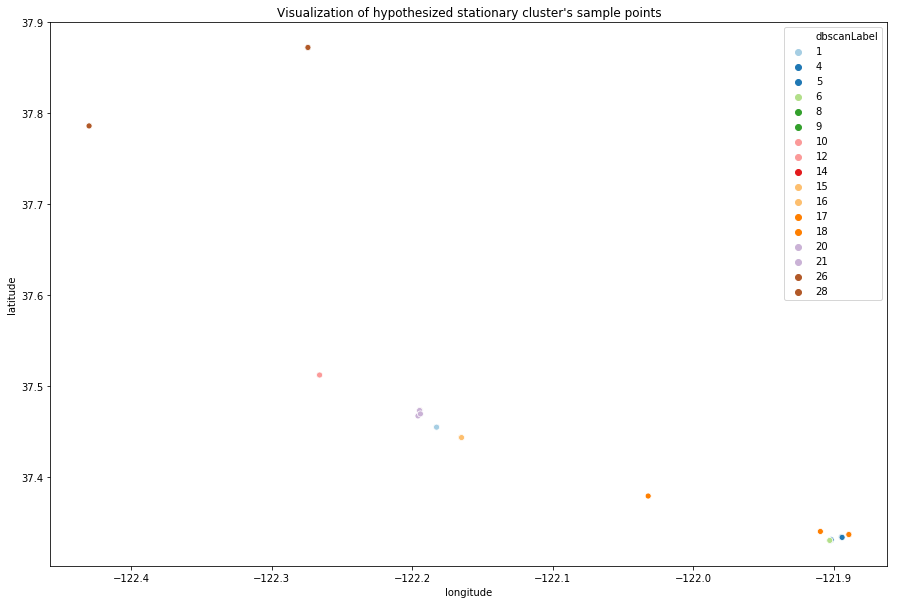

In [491]:
fig, ax = plt.subplots(figsize=[15, 10])
ax = sns.scatterplot(x="longitude", y="latitude", 
                     hue='dbscanLabel', legend='full',
                     palette='Paired', data=sampleDF)
plt.title("Visualization of hypothesized stationary cluster's sample points")

From the plot and the data frame above we see that:    

Cluster 1 is in Menlo Park(time around 9:40)    
Clusters 4, 5 and 6 are very close to each other in San Jose(time 18-19)      
Clusters 8, 9 and 10 are also close by in Menlo park(time around 20)      
Cluster 12 is in San Carlos(time around 21:50)       
Clusters 14, 15 and 16 is in Menlo Park again(time around 22-09 on next day)     
Cluster 17 in San Jose(time around 10)      
Cluster 18 has 2 points one in San Jose and other in Sunnyvale hence let's ignore it(time around 19)    
Cluster 20 is in Menlo Park(time around 22)    
Cluster 21 is in Atherton(time around 18 next day)    
Cluster 26 is in San Francisco(time around 19)    
Cluster 28 is in Berkeley(time around 23)     

From the above observations we can see the mobility of the user he starts from Atherton(as per the first record in the dataset) goes to Menlo Park and so on and ends up in Berkeley       

We also see that in the first figure where I plotted all the points that there was significant trail of points on all of the above mentioned locations.

<strong>Total number of Unique places visited = 6(Menlo Park, San Jose, San Carlos, Atherton, San Francisco, Berkeley)</strong>     
For Finding the top 3 locations lets see the amopunt of time the user spend in all these locations


In [500]:
enrichedDF.groupby('City')['timedelta'].sum().sort_values(ascending=False)

City
Atherton               74938.034
San Jose               65940.629
Menlo Park             52590.411
San Francisco          11012.689
Berkeley                6486.034
San Carlos              4926.204
Palo Alto               2549.999
Mountain View           1728.470
Sunnyvale               1517.737
Santa Clara             1245.164
Redwood City             668.080
San Mateo                475.175
Emeryville               291.999
South San Francisco      240.570
Brisbane                 237.515
Burlingame               190.775
Belmont                  158.964
Name: timedelta, dtype: float64

<strong>Top 3 locations: Atherton, San Jose and Menlo Park </strong>

### Other Insights of travel behaviour of the user     

As per the clusters generated above, we can say that the travel pattern of the User is as follows:

1. Starts at Atherton(based on first data point in dataset)
2. Goes to Menlo Park
3. Travels to San Jose
4. Comes back to Menlo Park
6. Goes to San Carlos
7. Comes back to Menlo Park
8. Goes to San Jose in the morning
9. Comes to Menlo Park in evening
10. Goes to San Francisco the Next day
11. then goes to Berkeley


The above pattern and the details of the time spent at each location signifies that the user stays in Atherton(somewhere around San Benito Ave.) goes to San Jose for work probably travels by train boarding the train at Menlo Park.

He went to San Francisco probably for dinner the next day and probably stayed at Berkeley for that night.
